In [ ]:
import pandas as pd
import kagglehub
import numpy as np
import tensorflow as tf

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/insurance


This cell loads in the data from Kaggle.

In [ ]:
# Load the dataset from the specified path
try:
  df = pd.read_csv(path + '/insurance.csv')
  print(df.head())
except FileNotFoundError:
  print(f"Error: File not found at {path + '/insurance.csv'}. Please check the path.")
except Exception as e:
  print(f"An error occurred: {e}")


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


Loads insurance.csv into a pandas dataframe.

**Describing the data**

In [ ]:
print("\nFirst five rows:")
print(df.head())

print("\nShape: ")
print(df.shape)

print("\nDescription of the data:")
print(df.describe(include='all'))

missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)

df_cleaned = df.dropna(inplace=False)

print("\nShape of the dataframe after dropping rows with missing values:")
print(df_cleaned.shape)

label_column = 'charges'
features = df_cleaned.drop(columns=[label_column])
label = df_cleaned[label_column]

print("\nFeatures:")
print(features.head())

print("\nLabel:")
print(label.head())


First five rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Shape: 
(1338, 7)

Description of the data:
                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000    

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the specified columns
enc.fit(features[['sex', 'smoker', 'region']])

# Transform the specified columns using the fitted encoder
num_sex = enc.transform(features[['sex', 'smoker', 'region']]).toarray()

# Create a new DataFrame from the encoded data
encoded_df = pd.DataFrame(num_sex, columns=enc.get_feature_names_out(['sex', 'smoker', 'region']))

# Concatenate the encoded DataFrame with the original DataFrame
features = pd.concat([features, encoded_df], axis=1)

# Drop original columns
features = features.drop(columns = ['sex', 'smoker', 'region'])

features = features.drop(columns = ['sex_female', 'smoker_no'])

print(features.head())

   age     bmi  children  sex_male  smoker_yes  region_northeast  \
0   19  27.900         0       0.0         1.0               0.0   
1   18  33.770         1       1.0         0.0               0.0   
2   28  33.000         3       1.0         0.0               0.0   
3   33  22.705         0       1.0         0.0               0.0   
4   32  28.880         0       1.0         0.0               0.0   

   region_northwest  region_southeast  region_southwest  
0               0.0               0.0               1.0  
1               0.0               1.0               0.0  
2               0.0               1.0               0.0  
3               1.0               0.0               0.0  
4               1.0               0.0               0.0  


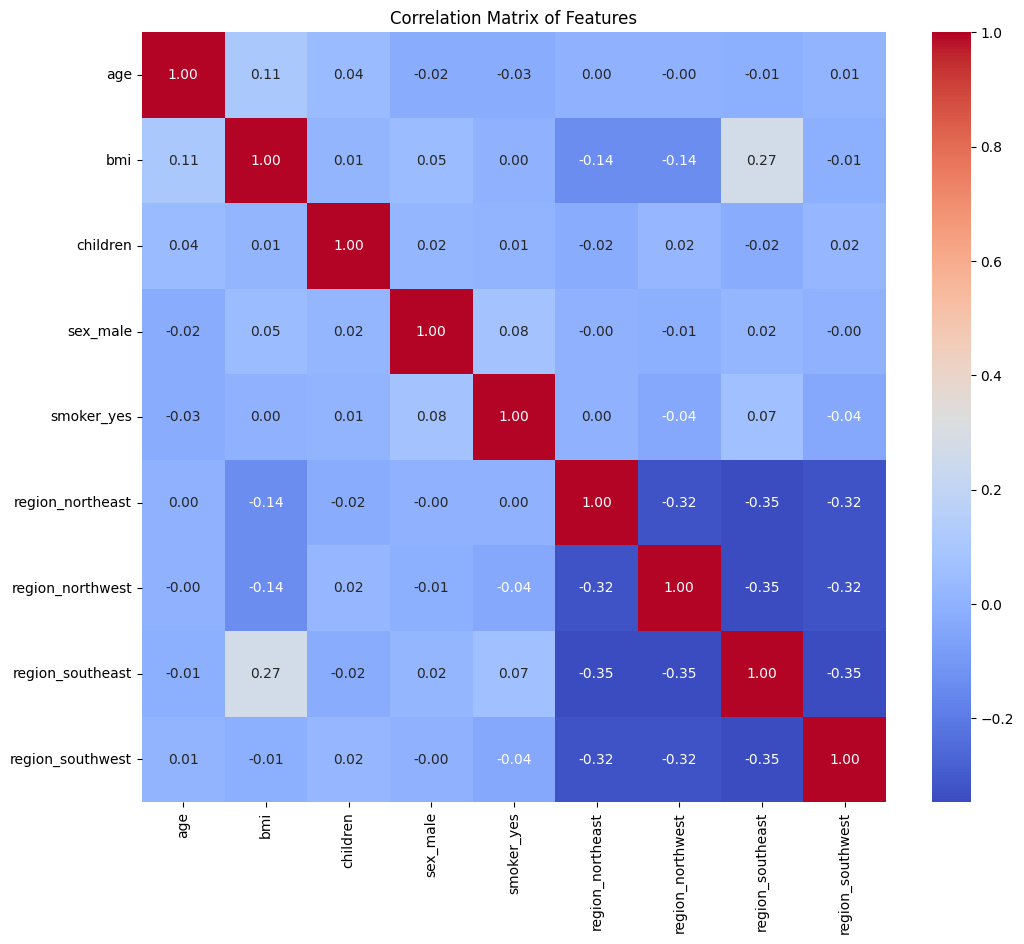

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# Define features (X) and target (y)
X = features
y = label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 1. Linear Regression (No hyperparameters to tune)
lm = LinearRegression()
lm.fit(X_train, y_train)

# 2. Hyperparameter Tuning for Decision Tree
dt_params = {'max_depth': [3, 5, 10, None],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

# 3. Hyperparameter Tuning for Random Forest
rf_params = {'n_estimators': [50, 100, 200],
             'max_depth': [3, 5, 10, None],
             'max_features': ['sqrt', 'log2'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# Display the best parameters for each model
print("Best Decision Tree Parameters:", dt_grid.best_params_)
print("Best Random Forest Parameters:", rf_grid.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# Feature importance for Decision Tree and Random Forest
importance = pd.DataFrame({
    'Variable': X.columns,
    'DT Importance': dt_best.feature_importances_,
    'RF Importance': rf_best.feature_importances_
}).sort_values(by='RF Importance', ascending=False)

print("\nFeature Importance:")
print(importance)


Feature Importance:
           Variable  DT Importance  RF Importance
4        smoker_yes       0.709827       0.643408
1               bmi       0.172614       0.151706
0               age       0.117559       0.148843
2          children       0.000000       0.023665
3          sex_male       0.000000       0.008782
5  region_northeast       0.000000       0.006773
8  region_southwest       0.000000       0.005689
6  region_northwest       0.000000       0.005579
7  region_southeast       0.000000       0.005555


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions for Linear Regression
yhat_train_lm = lm.predict(X_train).squeeze()
yhat_test_lm = lm.predict(X_test).squeeze()

# Predictions for Best Decision Tree
yhat_train_dt = dt_best.predict(X_train).squeeze()
yhat_test_dt = dt_best.predict(X_test).squeeze()

# Predictions for Best Random Forest
yhat_train_rf = rf_best.predict(X_train).squeeze()
yhat_test_rf = rf_best.predict(X_test).squeeze()

# Evaluate the models
print("\nLinear Regression")
print("Train MSE: ", mean_squared_error(y_train, yhat_train_lm))
print("Test MSE: ", mean_squared_error(y_test, yhat_test_lm))
print("R² Score: ", r2_score(y_test, yhat_test_lm))

print("\nDecision Tree")
print("Train MSE: ", mean_squared_error(y_train, yhat_train_dt))
print("Test MSE: ", mean_squared_error(y_test, yhat_test_dt))
print("R² Score: ", r2_score(y_test, yhat_test_dt))

print("\nRandom Forest")
print("Train MSE: ", mean_squared_error(y_train, yhat_train_rf))
print("Test MSE: ", mean_squared_error(y_test, yhat_test_rf))
print("R² Score: ", r2_score(y_test, yhat_test_rf))


Linear Regression
Train MSE:  37268977.7668648
Test MSE:  35090225.725625664
R² Score:  0.7605492639270064

Decision Tree
Train MSE:  20720003.354668073
Test MSE:  24288655.7426433
R² Score:  0.8342576493729357

Random Forest
Train MSE:  8330180.977803086
Test MSE:  21290029.86402488
R² Score:  0.8547198481475178


The following is stuff I just started trying. Not sure if we need it or not - Amelia

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

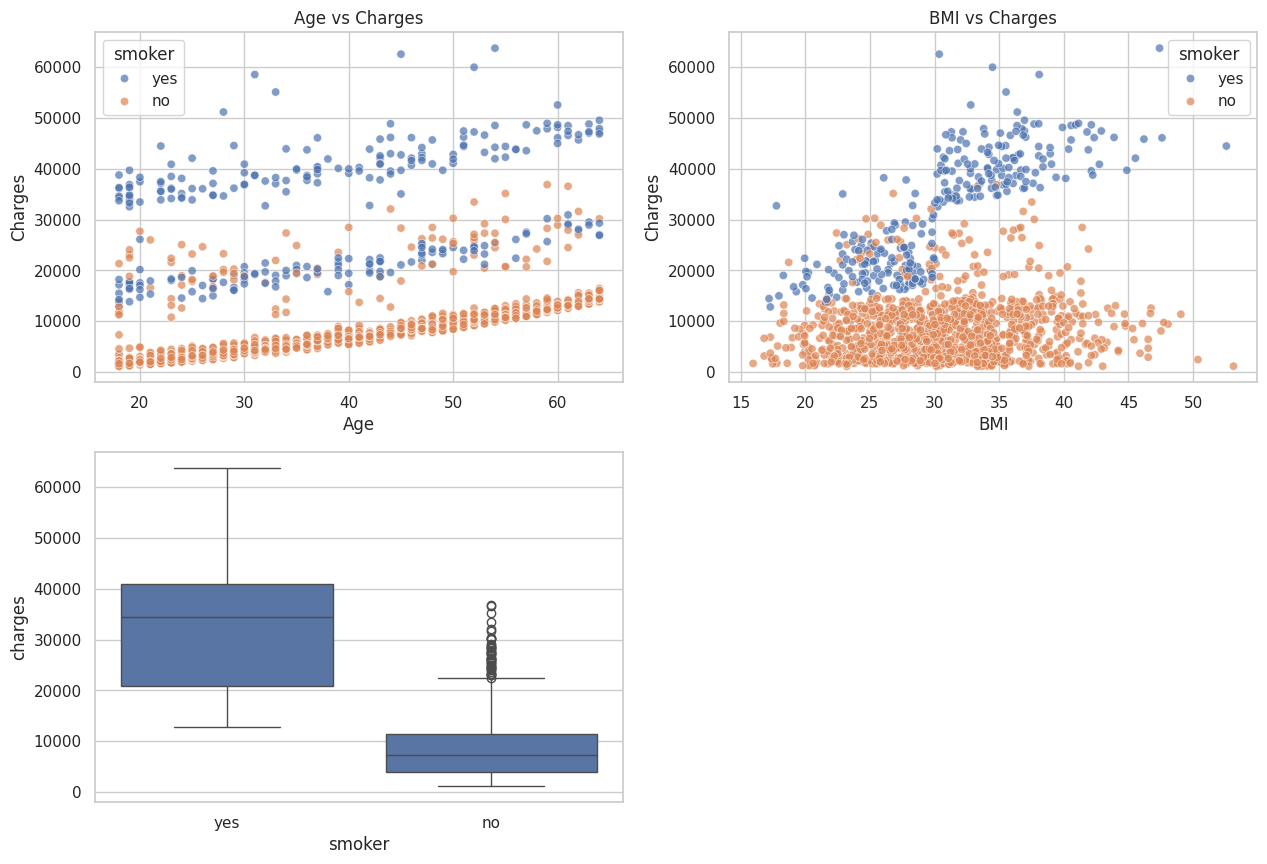

In [ ]:
# Visualizations

import seaborn as sns
import matplotlib.pyplot as plt

# Set style for plots
sns.set(style="whitegrid")

# Create visualizations
plt.figure(figsize=(15, 10))

# Age vs Charges
plt.subplot(2, 2, 1)
sns.scatterplot(x=df_cleaned['age'], y=df_cleaned['charges'], hue=df_cleaned['smoker'], alpha=0.7)
plt.title("Age vs Charges")
plt.xlabel("Age")
plt.ylabel("Charges")

# BMI vs Charges
plt.subplot(2, 2, 2)
sns.scatterplot(x=df_cleaned['bmi'], y=df_cleaned['charges'], hue=df_cleaned['smoker'], alpha=0.7)
plt.title("BMI vs Charges")
plt.xlabel("BMI")
plt.ylabel("Charges")

# Charges by Smoker Status
plt.subplot(2, 2, 3)
sns.boxplot(x=df_cleaned['smoker'], y=df_cleaned['charges'])
plt

In [ ]:
# Model Evaluation

from sklearn.metrics import mean_squared_error, r2_score

# Define a function to evaluate model performance
def evaluate_model(y_train, y_pred_train, y_test, y_pred_test, model_name):
    """
    Evaluate a model using MSE and R-squared metrics.
    """
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"{model_name} Performance:")
    print(f"  Train MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
    print(f"  Test MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
    print("-" * 40)

# Evaluate models
evaluate_model(y_train, yhat_train_lm, y_test, yhat_test_lm, "Linear Regression")
evaluate_model(y_train, yhat_train_dt, y_test, yhat_test_dt, "Decision Tree")
evaluate_model(y_train, yhat_train_rf, y_test, yhat_test_rf, "Random Forest")


Linear Regression Performance:
  Train MSE: 37268977.77, R-squared: 0.75
  Test MSE: 35090225.73, R-squared: 0.76
----------------------------------------
Decision Tree Performance:
  Train MSE: 20720003.35, R-squared: 0.86
  Test MSE: 24288655.74, R-squared: 0.83
----------------------------------------
Random Forest Performance:
  Train MSE: 8330180.98, R-squared: 0.94
  Test MSE: 21290029.86, R-squared: 0.85
----------------------------------------


<ipython-input-21-9a9736bf3d8f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RF Importance', y='Variable', data=importance_sorted, palette="viridis")


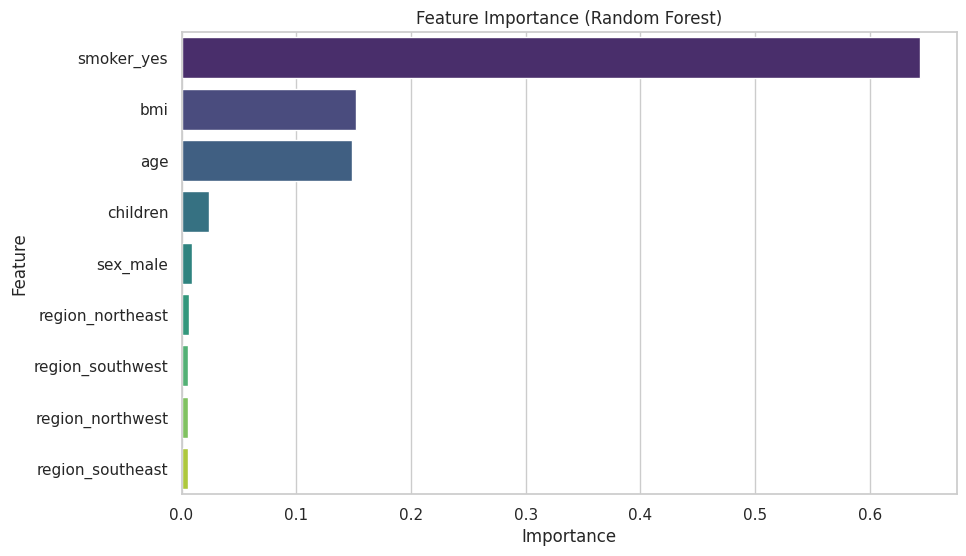

In [ ]:
# Feature Importance Visualization

importance_sorted = importance.sort_values(by='RF Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='RF Importance', y='Variable', data=importance_sorted, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
Model = model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 1000, verbose = 0)

In [ ]:
plt.plot(Model.history['mean_squared_error'])
plt.title('Loss Function Over Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
mse = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Mean Squared Error (MSE) of the neural network: {mse}")

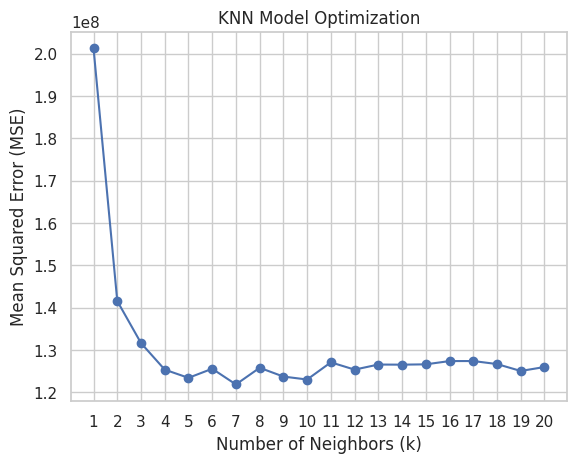

Optimal number of neighbors: 7
KNN Mean Squared Error (MSE): 121885025.6497124


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Optimize the number of neighbors
cv_errors = []
k_values = range(1, 21)  # Try k from 1 to 20

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    cv_error = mean_squared_error(y_test, knn.predict(X_test))
    cv_errors.append(cv_error)

# Plot MSE vs k
plt.plot(k_values, cv_errors, marker='o')  # Added markers for better visibility
plt.title('KNN Model Optimization')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(k_values)  # Ensure the x-axis uses whole numbers
plt.grid(True)
plt.show()

# Identify the optimal k
optimal_k = k_values[np.argmin(cv_errors)]
print(f"Optimal number of neighbors: {optimal_k}")

knn = KNeighborsRegressor(n_neighbors=optimal_k)

# Fit the KNN model on the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN Mean Squared Error (MSE): {mse_knn}")